# Econometrics 2

## TD 1 


#### 1.Import the data in Stata and graph the times series bib6 and bib8, the number of banks in business for each district. Indicate the Caldwell’s collapse (November 1st of 1930) and the bank run (December 19th of 1930).

In [1]:
# Import data
library ( dplyr )
library ( tidyr )
library ( ggplot2 )
library ( haven )
# install . packages (" lubridate ")
library ( lubridate )


Attachement du package : ‘dplyr’


Les objets suivants sont masqués depuis ‘package:stats’:

    filter, lag


Les objets suivants sont masqués depuis ‘package:base’:

    intersect, setdiff, setequal, union



Attachement du package : ‘lubridate’


Les objets suivants sont masqués depuis ‘package:base’:

    date, intersect, setdiff, union




In [3]:
data <- read_dta("banks_TD1.dta")

# Résumé des données
summary(data)

# ### Question 1 ####
# Ajouter des labels
data <- data %>%
  mutate(
    bib6_label = "District 6 (supervised by the Atlanta FED) - Treated",
    bib8_label = "District 8 (supervised by the St Louis FED) - Control"
  )

      date                 bib6            bib8         month       
 Min.   :1929-07-01   Min.   :102.0   Min.   :109   Min.   : 1.000  
 1st Qu.:1930-10-13   1st Qu.:105.0   1st Qu.:111   1st Qu.: 4.000  
 Median :1932-01-25   Median :114.0   Median :121   Median : 7.000  
 Mean   :1932-01-25   Mean   :118.6   Mean   :133   Mean   : 6.548  
 3rd Qu.:1933-05-08   3rd Qu.:133.0   3rd Qu.:165   3rd Qu.: 9.000  
 Max.   :1934-08-21   Max.   :142.0   Max.   :170   Max.   :12.000  
      day             year     
 Min.   : 1.00   Min.   :1929  
 1st Qu.: 8.00   1st Qu.:1930  
 Median :16.00   Median :1932  
 Mean   :15.68   Mean   :1932  
 3rd Qu.:23.00   3rd Qu.:1933  
 Max.   :31.00   Max.   :1934  

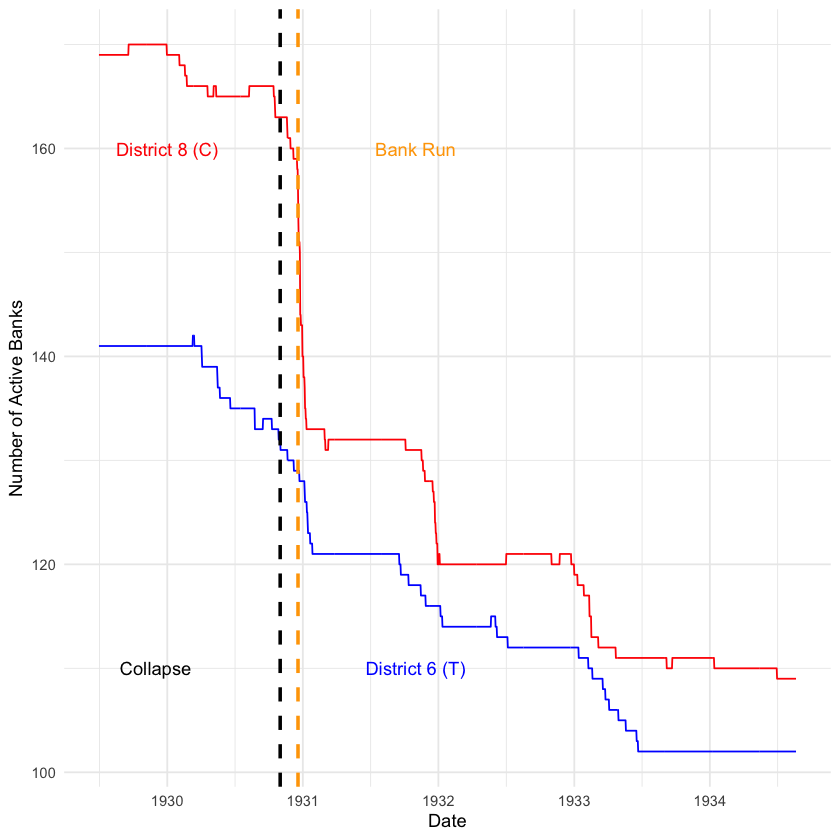

In [5]:
# Création du graphique avec ggplot2
ggplot(data) +
  geom_line(aes(x = date, y = bib6), color = "blue", linetype = "solid") +
  geom_line(aes(x = date, y = bib8), color = "red", linetype = "solid") +
  geom_vline(xintercept = as.Date("1930-11-01"), linetype = "dashed", color = "black", linewidth = 1) +
  geom_vline(xintercept = as.Date("1930-12-19"), linetype = "dashed", color = "orange", linewidth = 1) +
  annotate("text", x = as.Date("1930-01-01"), y = 160, label = "District 8 (C)", color = "red") +
  annotate("text", x = as.Date("1931-11-01"), y = 110, label = "District 6 (T)", color = "blue") +
  annotate("text", x = as.Date("1929-12-01"), y = 110, label = "Collapse", color = "black") +
  annotate("text", x = as.Date("1931-11-01"), y = 160, label = "Bank Run", color = "orange") +
  labs(y = "Number of Active Banks", x = "Date") +
  theme_minimal()


#### 2. Select data corresponding to the 1st July of each year. Compute the number of bank in activity for each year in each district and draw the corresponding graph. Draw the number of banks in each district and the counterfactual derived from a DiD strategy.

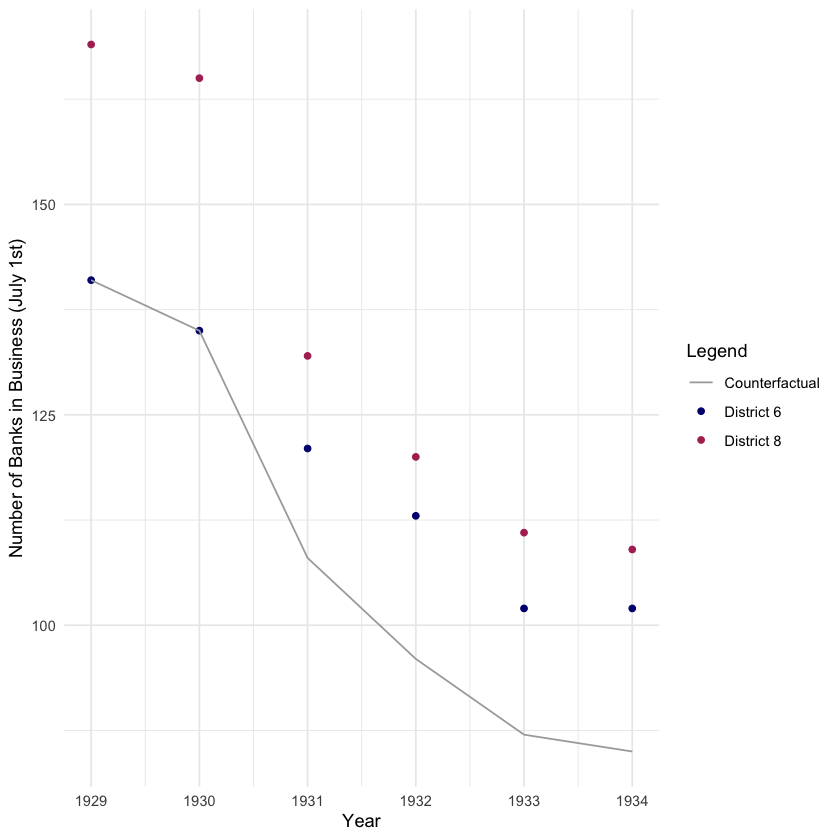

In [7]:
# Filtrer les observations pour le 1er juillet
data_july <- data %>%
  filter(month(date) == 7, day(date) == 1)

# Générer un contrefactuel
data_july <- data_july %>%
  mutate(diff = bib8 - lag(bib8, default = first(bib8))) %>%
  mutate(diff = ifelse(year == 1930, 0, diff)) %>%
  mutate(cumdiff = cumsum(diff)) %>%
  mutate(bib6_29 = ifelse(year == 1930, bib6, first(bib6))) %>%
  mutate(bibc = bib6_29 + cumdiff)

# Graphique des niveaux avec contre-factuels
ggplot(data_july, aes(x = year(date))) +
  geom_point(aes(y = bib8, color = "District 8")) +
  geom_point(aes(y = bib6, color = "District 6")) +
  geom_line(aes(y = bibc, color = "Counterfactual")) +
  scale_color_manual(values = c("District 8" = "maroon",
                                "District 6" = "navy",
                                "Counterfactual" = "darkgray")) +
  labs(y = "Number of Banks in Business (July 1st)", 
       x = "Year", 
       color = "Legend") +
  theme_minimal()

### 3. Make some robustness check considering other day than July 1st (for instance September 15th).

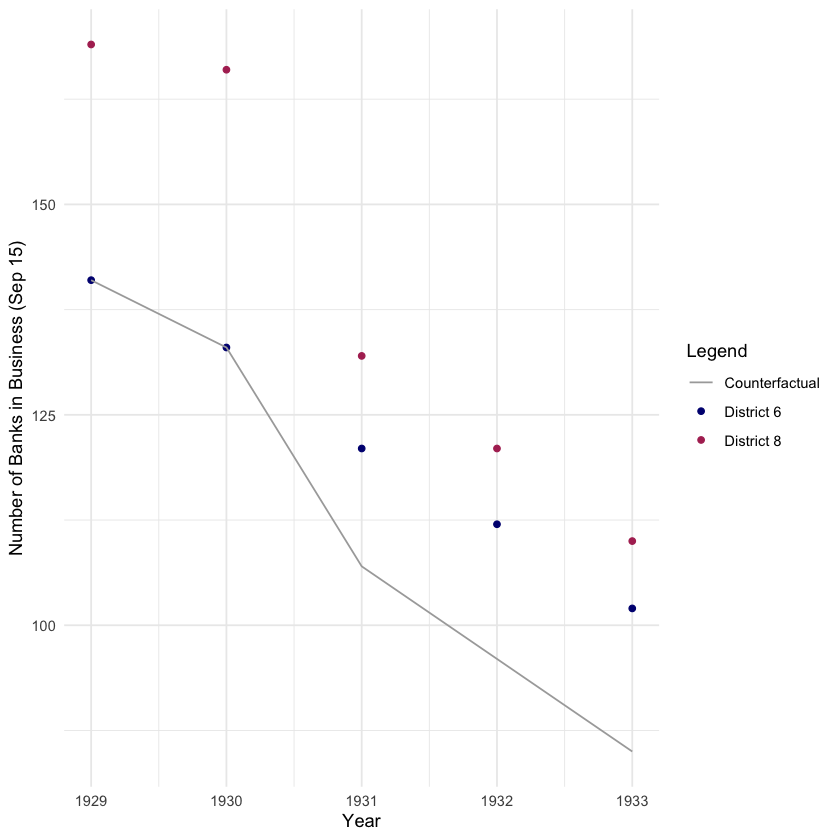

In [8]:
# Filter observations for September 15
data_sept <- data %>%
  filter(month(date) == 9, day(date) == 15)

# Generate the counterfactual
data_sept <- data_sept %>%
  mutate(diff = bib8 - lag(bib8)) %>%  # Difference for the control group
  mutate(diff = ifelse(is.na(diff), 0, diff)) %>%  # Replace NA differences with 0
  mutate(diff = ifelse(year == 1930, 0, diff)) %>%  # Set difference to 0 for 1930
  mutate(cumdiff = cumsum(diff)) %>%  # Compute cumulative sum of the differences
  mutate(bib6_29 = ifelse(year == 1930, bib6, first(bib6))) %>%  # Create the counterfactual base
  mutate(bibc = bib6_29 + cumdiff)  # Construct the counterfactual trend

# Plot levels with counterfactuals for September
ggplot(data_sept, aes(x = year(date))) +
  geom_point(aes(y = bib8, color = "District 8")) +
  geom_point(aes(y = bib6, color = "District 6")) +
  geom_line(aes(y = bibc, color = "Counterfactual")) +
  scale_color_manual(values = c("District 8" = "maroon",
                                "District 6" = "navy",
                                "Counterfactual" = "darkgray")) +
  labs(y = "Number of Banks in Business (Sep 15)", x = "Year", color = "Legend") +
  theme_minimal()


### 4. Estimate the average marginal effect of the Atlanta policy on the probability to survive between July 1st 1930 and July 1st 1931. Test the nullity of this average effect (assuming that no new bank appears during this period). [Note : to do so you can build a dataset of banks × years and run an OLS regression.]

In [11]:
install.packages("fixest")
# Load necessary libraries
library(dplyr)
library(fixest)

installation des dépendances ‘dreamerr’, ‘stringmagic’


Mise à jour de la liste HTML des packages dans '.Library'

Making 'packages.html' ...
 terminé



In [12]:
# We generate a panel database where each row corresponds to a bank i in year t.
# We assume that no new banks emerge during the period under consideration .
# If a bank i exists in year t, then Y_it = 1.
# Otherwise , it is equal to 0. In 1930 , there were 165 banks in district 8 and 135 banks in district 6.
# We consider a span of 2 periods .

# Generate a panel database where each row corresponds to a bank i in year t
n_bank <- 300  # 2 periods x (165 District 8 + 135 District 6)
panel_data <- data.frame(
  ind_bank = rep(1:n_bank, 2),
  year = c(rep(1930, n_bank), rep(1931, n_bank)),
  G = rep(c(rep(1, 135), rep(0, 165)), 2)  # 1 = District 6 (Treated), 0 = District 8 (Control)
)

# Add treatment and outcome variables
panel_data <- panel_data %>%
  mutate(
    Y = 1,  # Bank exists in year t
    Y = if_else(year == 1931 & G == 1 & ind_bank > 121, 0, Y),  # Some banks in District 6 close
    Y = if_else(year == 1931 & G == 0 & ind_bank > (135+132), 0, Y),  # Some banks in District 8 close
    D = if_else(year == 1931 & G == 1, 1, 0),  # Treatment (Great Depression effect on treated banks)
    T = if_else(year == 1931, 1, 0)  # Post-treatment period
  )

# Regression for the main DiD estimation
model <- feols(Y ~ D | T + G, data = panel_data, cluster = "ind_bank")
summary(model)

# ---- Question for students ----
# Why do we use the "cluster" option at the bank level?
# Answer: Clustering accounts for the fact that observations within the same bank are not independent over time.
# It corrects standard errors for potential serial correlation and heteroskedasticity.

# ### Extension: DiD analysis over multiple periods ####

n_bank_long <- 310  # 6 periods x (169 District 8 + 141 District 6)
panel_data_long <- data.frame(
  ind_bank = rep(1:n_bank_long, 6),
  year = rep(1929:1934, each = n_bank_long),
  G = rep(c(rep(1, 141), rep(0, 169)), 6)  # 1 = District 6, 0 = District 8
)

# Add the outcome variable Y based on survival conditions
panel_data_long <- panel_data_long %>%
  mutate(
    Y = 1,
    Y = if_else(year == 1930 & G == 1 & ind_bank > 135, 0, Y),
    Y = if_else(year == 1931 & G == 1 & ind_bank > 121, 0, Y),
    Y = if_else(year == 1932 & G == 1 & ind_bank > 113, 0, Y),
    Y = if_else(year == 1933 & G == 1 & ind_bank > 102, 0, Y),
    Y = if_else(year == 1934 & G == 1 & ind_bank > 102, 0, Y),
    Y = if_else(year == 1930 & G == 0 & ind_bank > 141 + 165, 0, Y),
    Y = if_else(year == 1931 & G == 0 & ind_bank > 141 + 132, 0, Y),
    Y = if_else(year == 1932 & G == 0 & ind_bank > 141 + 120, 0, Y),
    Y = if_else(year == 1933 & G == 0 & ind_bank > 141 + 111, 0, Y),
    Y = if_else(year == 1934 & G == 0 & ind_bank > 141 + 109, 0, Y),

    # Define period-specific treatment variables
    D_minus_1 = if_else(year == 1929 & G == 1, 1, 0),
    D_1 = if_else(year == 1931 & G == 1, 1, 0),
    D_2 = if_else(year == 1932 & G == 1, 1, 0),
    D_3 = if_else(year == 1933 & G == 1, 1, 0),
    D_4 = if_else(year == 1934 & G == 1, 1, 0)
  )

# Regression for the long-term effect
long_term_model <- feols(Y ~ D_minus_1 + D_1 + D_2 + D_3 + D_4 | G + factor(year), 
                         data = panel_data_long, cluster = "ind_bank")
summary(long_term_model)


OLS estimation, Dep. Var.: Y
Observations: 600
Fixed-effects: T: 2,  G: 2
Standard-errors: Clustered (ind_bank) 
  Estimate Std. Error t value Pr(>|t|)    
D 0.096296   0.040892 2.35491 0.019173 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.254781     Adj. R2: 0.09636 
                 Within R2: 0.008761

OLS estimation, Dep. Var.: Y
Observations: 1,860
Fixed-effects: G: 2,  factor(year): 6
Standard-errors: Clustered (ind_bank) 
          Estimate Std. Error  t value Pr(>|t|)    
D_minus_1 0.018885   0.020727 0.911108 0.362949    
D_1       0.095975   0.039730 2.415689 0.016285 *  
D_2       0.110244   0.045926 2.400458 0.016966 *  
D_3       0.085484   0.050809 1.682473 0.093487 .  
D_4       0.097318   0.051051 1.906305 0.057538 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.363794     Adj. R2: 0.108766
                 Within R2: 0.003351